<a href="https://colab.research.google.com/github/shhhQuiettt/image-colorization/blob/main/firstTo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation_models_pytorch
!pip install torch_summary
!pip install torchinfo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ColorJitter, ToTensor
from torch.utils.data import Dataset
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_DIR = "/content/drive/MyDrive/image_colorization_data/train"
VAL_DIR = "/content/drive/MyDrive/image_colorization_data/val"
TEST_DIR = "/content/drive/MyDrive/image_colorization_data/test"
MODELS_DIR = "/content/drive/MyDrive/image_colorization_data/models"
# assert that the dirs exist

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(VAL_DIR)
assert os.path.exists(TEST_DIR)
assert os.path.exists(MODELS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
import cv2
import os

class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.crop_size = (448, 448)

        self.colored_images_filenames = sorted(os.listdir(os.path.join(image_dir, "color")))
        self.grayscale_images_filenames = sorted(os.listdir(os.path.join(image_dir, "gray")))

        self.data = [
            self.load_item(idx)
            for idx in range(len(self.colored_images_filenames))
        ]

        assert len(self.colored_images_filenames) == len(self.grayscale_images_filenames)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        gray_image, color_image = self.data[idx]

        pad_if_needed = A.PadIfNeeded(min_height=self.crop_size[0], min_width=self.crop_size[1])
        color_image = pad_if_needed(image=color_image)["image"]
        gray_image = pad_if_needed(image=gray_image)["image"]

        color_image = F.to_tensor(color_image)
        gray_image = F.to_tensor(gray_image)

        i, j, h, w = T.RandomCrop.get_params(color_image, self.crop_size)

        color_image = F.crop(color_image, i, j, h, w)
        gray_image = F.crop(gray_image, i, j, h, w)

        return gray_image, color_image

    def set_crop_size(self, crop_size):
        self.crop_size = crop_size

    def load_item(self, idx):
        if idx % 500 == 0:
          print(f"Loading item {idx}")
        colored_path = os.path.join(self.image_dir, "color", self.colored_images_filenames[idx])
        grayscale_path = os.path.join(self.image_dir, "gray", self.grayscale_images_filenames[idx])

        color_image = cv2.imread(colored_path)
        assert color_image is not None, f"Failed to read image: {colored_path}"
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2LAB)

        gray_image = cv2.imread(grayscale_path, cv2.IMREAD_GRAYSCALE)
        assert gray_image is not None, f"Failed to read image: {grayscale_path}"

        return gray_image, color_image[:,:,1:]




train_dataset = ImageDataset(TRAIN_DIR)
val_dataset = ImageDataset(VAL_DIR)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Loading item 0
Loading item 500
Loading item 1000
Loading item 1500
Loading item 2000
Loading item 2500
Loading item 3000
Loading item 3500
Loading item 4000
Loading item 4500
Loading item 5000
Loading item 5500
Loading item 6000
Loading item 6500
Loading item 7000
Loading item 0
Loading item 500


In [ ]:
# average image size and std

running_width = 0
runing_height = 0

running_squared_width = 0
running_squared_height = 0

for i in range(len(train_dataset)):
  gray_image, _ = train_dataset.data[i]
  running_width += gray_image.shape[1]
  runing_height += gray_image.shape[0]

  running_squared_width += gray_image.shape[1] ** 2
  running_squared_height += gray_image.shape[0] ** 2

avg_widht = running_width / len(train_dataset)
avg_height = runing_height / len(train_dataset)


std_width = (running_squared_width / len(train_dataset) - avg_widht ** 2) ** 0.5
std_height = (running_squared_height / len(train_dataset) - avg_height ** 2) ** 0.5

print(f"Average width: {avg_widht} std: {std_width}")
print(f"Average height: {avg_height} std: {std_height}")



In [6]:
import segmentation_models_pytorch as smp
from torchsummary import summary
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation = "sigmoid"
).to(device)


summary(model,(1,1,448,448))

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 2, 448, 448]          --
├─ResNetEncoder: 1-1                          [1, 1, 448, 448]          --
│    └─Conv2d: 2-1                            [1, 64, 224, 224]         3,136
│    └─BatchNorm2d: 2-2                       [1, 64, 224, 224]         128
│    └─ReLU: 2-3                              [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                         [1, 64, 112, 112]         --
│    └─Sequential: 2-5                        [1, 256, 112, 112]        --
│    │    └─Bottleneck: 3-1                   [1, 256, 112, 112]        75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 112, 112]        70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 112, 112]        70,400
│    └─Sequential: 2-6                        [1, 512, 56, 56]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 56, 56]          379,392

# Trainer

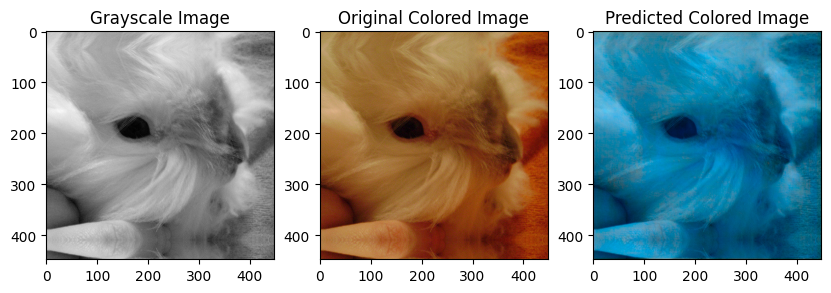

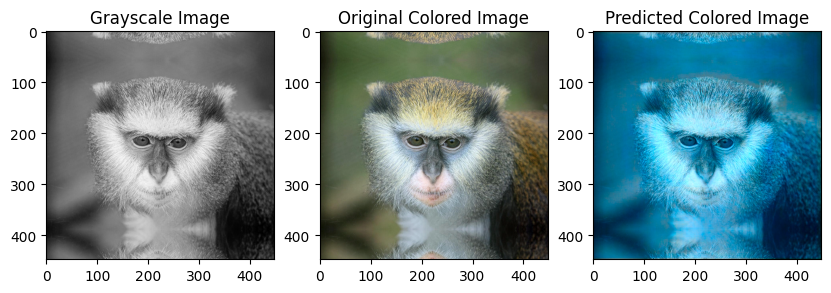

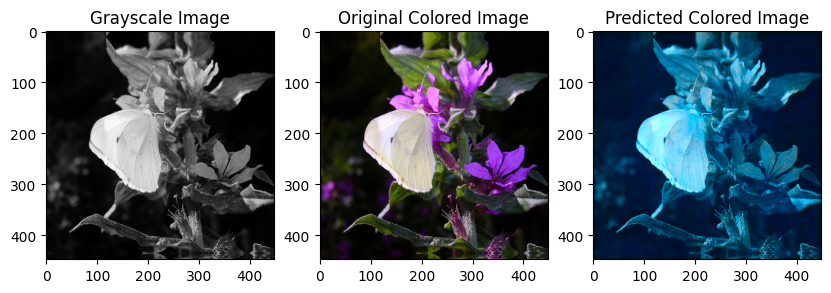

In [7]:
def display_first_results(model):
    model.eval()
    with torch.no_grad():
      for i in range(3):
          gray, ab = val_dataset[i]
          predicted_ab = model(torch.unsqueeze(gray.to(device),0)).squeeze().permute(1,2,0).cpu().numpy()

          gray = gray.squeeze()
          ab = torch.permute(ab.squeeze(), (1, 2 ,0 ))

          gray_np = (255*gray.numpy()).astype(np.uint8)
          ab_np = (255*ab.numpy()).astype(np.uint8)

          colored_img = np.dstack((gray_np, ab_np))

          colored_img = cv2.cvtColor(colored_img, cv2.COLOR_LAB2RGB)

          predicted_ab = (predicted_ab * 255).astype(np.uint8)
          predicted_img = np.dstack((gray_np, predicted_ab))
          predicted_img = cv2.cvtColor(predicted_img, cv2.COLOR_LAB2RGB)

          fig, axes = plt.subplots(1, 3, figsize=(10, 5))
          axes[0].imshow(gray_np, cmap='gray')
          axes[0].set_title('Grayscale Image')
          axes[1].imshow(colored_img)
          axes[1].set_title('Original Colored Image')
          axes[2].imshow(predicted_img)
          axes[2].set_title('Predicted Colored Image')
          plt.show()


display_first_results(model)

In [8]:
BEST_MODEL_PATH = os.path.join(MODELS_DIR, "best_model.pth")

class Trainer:
    def __init__(
        self,
        *,
        model,
        loss_function,
        train_loader,
        val_loader,
        optimizer,
        checkpoint_suffix,
    ):

        if (num_of_gpu := torch.cuda.device_count()) > 1:
            self.model = torch.nn.DataParallel(model, device_ids = [i for i in range(num_of_gpu)]).to(device)
        else:
            self.model = model.to(device)


        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

        self.checkpoint_suffix = checkpoint_suffix


    def train_one_epoch(self):
        self.model.train()
        running_loss = 0

        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            assert X_batch.shape[-2:] == y_batch.shape[-2:], f"{X_batch.shape[-2:]=} {y_batch.shape[-2:]=}"

            self.optimizer.zero_grad()
            y_batch_prediced = self.model(X_batch)
            assert y_batch_prediced.shape == y_batch.shape, f"{y_batch_prediced.shape=} {y_batch.shape=}"

            loss = self.loss_function(y_batch_prediced, y_batch)
            loss.backward()

            self.optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(self.train_loader)


        return epoch_loss

    def validate(self):
        self.model.eval()
        running_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_prediced = self.model(X_batch)
                loss = self.loss_function(y_batch_prediced, y_batch)

                running_loss += loss.item()


        epoch_loss = running_loss / len(self.val_loader)

        return epoch_loss

    def train(self, epochs: int, patience: int):
        best_loss = np.inf
        no_improvement = 0
        for epoch in range(epochs):
            train_loss = self.train_one_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)


            print("----------------------")
            print(f"Epoch: {epoch}: train loss: {train_loss}, validation loss: {val_loss}")

            # Early stopping
            if val_loss < best_loss:
                no_improvement = 0
                best_loss = val_loss
                torch.save(self.model.state_dict(), BEST_MODEL_PATH)

                checkpoint_name = f"best_model_{self.checkpoint_suffix}.pth"
                checkpoint_path = os.path.join(MODELS_DIR, checkpoint_name)
                torch.save(self.model.state_dict(), checkpoint_path)

            else:
                no_improvement += 1
                if no_improvement == patience:
                    print(f"Stopped early! Epochs with no improvement: {no_improvement}, (patience: {patience})")
                    break




    def plot(self, title=None):
        title = "Loss" if title is None else title
        plt.plot(self.train_losses, label="Train")
        plt.plot(self.val_losses, label="Validation")

        plt.title(title)
        plt.legend()

        plt.show()





----------------------
Epoch: 0: train loss: 0.039680711711216184, validation loss: 0.03666584373318723
----------------------
Epoch: 1: train loss: 0.03768416754407993, validation loss: 0.03704984615822988
----------------------
Epoch: 2: train loss: 0.03717904452390755, validation loss: 0.03622439982635634
----------------------
Epoch: 3: train loss: 0.0368194751046746, validation loss: 0.036428764961393814
----------------------
Epoch: 4: train loss: 0.036496812370801074, validation loss: 0.0357295678196741
----------------------
Epoch: 5: train loss: 0.03622627032562992, validation loss: 0.03593263924787087
----------------------
Epoch: 6: train loss: 0.03604264816404968, validation loss: 0.03630121181985097
----------------------
Epoch: 7: train loss: 0.03570959877395472, validation loss: 0.035618443274870515
----------------------
Epoch: 8: train loss: 0.03546938999961017, validation loss: 0.03611327408413802
----------------------
Epoch: 9: train loss: 0.0354991987610758, valida

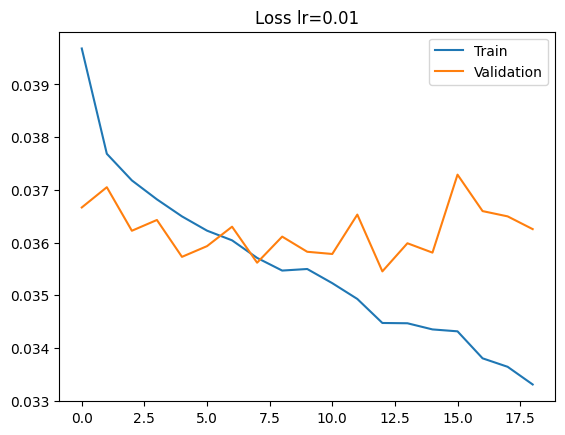

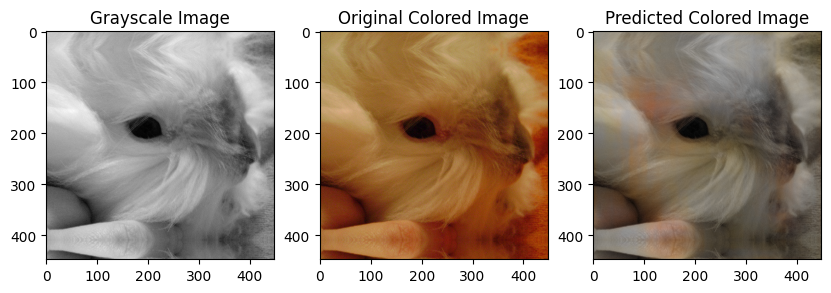

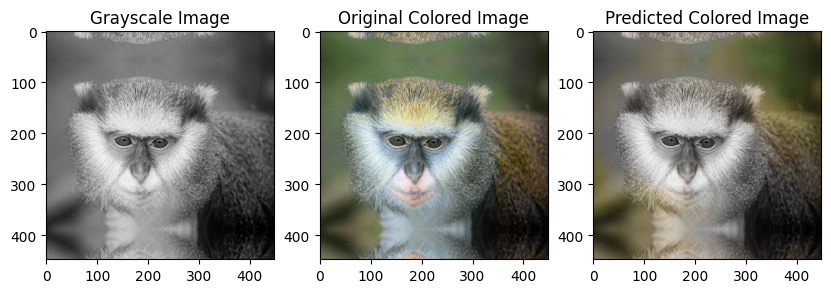

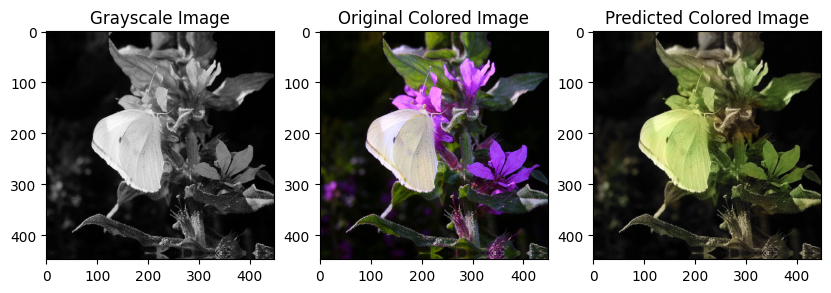

In [9]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation = "sigmoid"
).to(device)

loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for param in model.encoder.parameters():
    param.requires_grad = False

trainer = Trainer(
    model=model,
    loss_function=loss_function,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
    checkpoint_suffix="initial"
)
trainer.train(epochs=50, patience=6)
trainer.plot("Loss lr=0.01")
display_first_results(model)


In [ ]:
model_transfer = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation = "sigmoid"
).to(device)


model_transfer.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
for param in model_transfer.encoder.parameters():
    param.requires_grad = False

trainer = Trainer(
    model=model_transfer,
    loss_function=loss_function,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adam(model_transfer.parameters(), lr=0.001),
    checkpoint_suffix="initial_low_lr"
)
trainer.train(epochs=50, patience=6)
trainer.plot("Loss after reducing lr to 0.001")
display_first_results(model_transfer)

----------------------
Epoch: 0: train loss: 0.0333272438808848, validation loss: 0.0357705601491034


In [ ]:
model_transfer = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation = "sigmoid"
).to(device)


model_transfer.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
for param in model_transfer.encoder.parameters():
    param.requires_grad = True

trainer = Trainer(
    model=model_transfer,
    loss_function=loss_function,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adam(model_transfer.parameters(), lr=0.0005),
    checkpoint_suffix="unfreeze_encoder"
)
trainer.train(epochs=50, patience=10)
trainer.plot("Loss after unfreezing the encoder")
display_first_results(model_transfer)

In [ ]:
# trainer = Trainer(
#     model=model,
#     loss_function=loss_function,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
# )
# trainer.train(epochs=50, patience=6)
# trainer.plot("Loss after reducing lr to 0.001")
# # display_first_results(model)

# for param in model.encoder.parameters():
#     param.requires_grad = True

# model = model.load_state_dict(torch.load("/content/model.pth"), weights_only=True).to(device)
# trainer = Trainer(
#     model=model,
#     loss_function=loss_function,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
# )
# trainer.train(epochs=50, patience=6)
# trainer.plot("Loss after unfreezing encoder lr=0.01")
# # display_first_results(model)


# model = model.load_state_dict(torch.load("/content/model.pth"),weights_only=True).to(device)
# trainer = Trainer(
#     model=model,
#     loss_function=loss_function,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
# )
# trainer.train(epochs=50, patience=6)
# trainer.plot("Loss after unfreezing encoder and reducing lr to 0.01")
# # display_first_results(model)
